In [1]:
ENV = 'VAST' # Colab, VAST, Kaggle

In [2]:
import pandas as pd
import numpy as np
import os


import cv2
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torch.utils.data import Dataset, DataLoader

#from tqdm import tqdm

# tqdm doesn't work well in colab.
# This is the solution:
# https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
import tqdm.notebook as tq
#for i in tq.tqdm(...):

from tqdm import tqdm_notebook as tqdm

import gc


import albumentations as albu
from albumentations import Compose


from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, jaccard_score
import itertools


# load image with Pillow
from PIL import Image

from numpy import asarray

from skimage.transform import resize


import matplotlib.pyplot as plt

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Note: Pytorch uses a channels-first format:
# [batch_size, num_channels, height, width]

print(torch.__version__)

print(torchvision.__version__)

1.12.0.dev20220327+cu113
0.13.0.dev20220327+cu113


In [3]:
# Set the seed values

import random

# Set the seed value all over the place to make this reproducible.
seed_val = 101

os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True

In [4]:
if torch.cuda.is_available():
    print('Num GPUs:', torch.cuda.device_count())
    print('GPU Type:', torch.cuda.get_device_name(0))

Num GPUs: 2
GPU Type: NVIDIA RTX A5000


In [5]:
IMAGES_FOLDER = 'images_dir'

if ENV == 'VAST':
    
    root = '/root'
    base_path = '/root/smart-mammo-data/'
    data_path = '/root/exp49_10f_df_data_w_folds.csv'
    

if ENV == 'Kaggle':
    
    root = '/kaggle/working'
    base_path = '../input/smart-mammo-data/'
    data_path = '../input/exp49-mammo-create-the-7-folds/df_data_w_folds.csv'
    
    
print(ENV)

VAST


In [6]:
os.listdir(base_path)

['VinDR-Mammo-Data',
 'bens_images_dir',
 'data_for_simulation',
 'df_data.csv',
 'df_data_bens.csv',
 'df_data_padded.csv',
 'exp06-spine-prepare-the-images-original-size.ipynb',
 'exp17-LOCAL-pad--prepare-the-images-original-size.ipynb',
 'exp33_best.pt',
 'images_dir',
 'v2_images_dir']

## Config

In [7]:
# This is the fold that Yolo is trained on
CHOSEN_FOLD = 0


# Yolo setup:
NUM_EPOCHS = 90

# The batch size must be a even number when using multiple GPUs
BATCH_SIZE = 32
IMAGE_SIZE = 1024 # Yolo will automatically resize the input images to this size.

NUM_CORES = os.cpu_count()
NUM_CORES

128

## Set up Yolov5 - For offline use

The Yolov5 model being used here needs to have the internet turned for training to work. However, it does not need to have the internet on during inference.

In [8]:
# Copy the yolov5 folder from the notebook to  /kaggle/working/
# The folder will be renamed yolov5 when copied.
# The yolov5-v5.0 folder also contains the trained weights.


if os.path.isdir(f'{root}/yolov5') == False:
    
    if ENV == 'Kaggle':
        shutil.copytree('../input/my-yolov5-for-offline-use/yolov5-v5.0', '/kaggle/working/yolov5')
        
    if ENV == 'VAST':
        shutil.copytree('my-yolov5-for-offline-use/yolov5-v5.0', f'{root}/yolov5')

In [9]:
!ls

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
VAST_Setup_Notebook_for_Mammo.ipynb   onstart.sh
exp49_10f_df_data_w_folds.csv	      ports.log
exp50-mammo-yolov5-5-0-yolov5l.ipynb  requirements.txt
input				      smart-mammo-data
my-yolov5-for-offline-use	      yolov5
onstart.log


## Load the train data

In [10]:
path = data_path

df_data = pd.read_csv(path)

print(df_data.shape)

df_data.head()

(1426, 20)


,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,path,num_findings,target,fold
0,517563a43eab4f90efc650fcb0d215d5,37d2595b7ec81bd31a18d26afdb0aabf,c54fbe3a374b9e157280479c4649b11a,L,MLO,2812,2012,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,test,../input/smart-mammo-data/images_dir/images_di...,1,0,2.0
1,f8894c9173aaa865bd43751eeeacd3b0,1225d3a302306aca94552c0f8c30fe2c,78dfa5f3dd380341cc17955f52279728,R,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,test,../input/smart-mammo-data/images_dir/images_di...,1,0,2.0
2,05783bf55ed93d5ec21d4e0e8546a5f0,da0aae7d4ed0388e3e15da1fd90af2e1,f9c2fd2f75598e0d7c311687693c31a7,R,CC,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,../input/smart-mammo-data/images_dir/images_di...,1,0,5.0
3,ea8a09a16763d310b4065fe94c6c04cd,b714ced6a887a6528768db77b239dcd9,58d70109b957243aeaf19b95ed5322d4,R,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,../input/smart-mammo-data/images_dir/images_di...,1,0,3.0
4,38c28cfa153bb4a7a1ade330738df1b7,9b0f078012d78f9ddc0fe2482a33bf28,6cf20761dccfd17caa6ae4877b744db5,R,CC,2812,2012,BI-RADS 1,DENSITY D,['No Finding'],NaN,NaN,NaN,NaN,NaN,test,../input/smart-mammo-data/images_dir/images_di...,1,0,7.0


## Process the train data

In [11]:
# Get the path to each image

def get_path(row):
    
    study_id = row['study_id']
    image_id = row['image_id']
    path = base_path + f'{IMAGES_FOLDER}/{IMAGES_FOLDER}/' + image_id + '.png'
    
    return path


df_data['path'] = df_data.apply(get_path, axis=1)

print(df_data.shape)

#df_data.head()

(1426, 20)


## Create a column for the bbox info

In [12]:
# Put the bbox info for each image into a list of bbox dicts


bbox_list = []

for i in range(0, len(df_data)):
    
    target = df_data.loc[i, 'target']
    study_slice = df_data.loc[i, 'image_id']
    
    if target == 1:
    
        xmin = df_data.loc[i, 'xmin']
        ymin = df_data.loc[i, 'ymin']
        xmax = df_data.loc[i, 'xmax']
        ymax = df_data.loc[i, 'ymax']
        
        x = round(xmin)
        y = round(ymin)
        width = round(xmax - xmin)
        height = round(ymax - ymin)

        bbox_dict ={
            'x': x,
            'y': y,
            'width': width,
            'height': height
        }

        bbox_list.append(bbox_dict)
        
    else:
        bbox_list.append('none')
        
        
# Add the bbox_list to df_data

df_data['boxes'] = bbox_list

#print(df_data.shape)

#df_data.head()

In [13]:
df_data.head(2)

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,...,xmin,ymin,xmax,ymax,split,path,num_findings,target,fold,boxes
0,517563a43eab4f90efc650fcb0d215d5,37d2595b7ec81bd31a18d26afdb0aabf,c54fbe3a374b9e157280479c4649b11a,L,MLO,2812,2012,BI-RADS 1,DENSITY C,['No Finding'],...,NaN,NaN,NaN,NaN,test,/root/smart-mammo-data/images_dir/images_dir/c...,1,0,2.0,none
1,f8894c9173aaa865bd43751eeeacd3b0,1225d3a302306aca94552c0f8c30fe2c,78dfa5f3dd380341cc17955f52279728,R,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],...,NaN,NaN,NaN,NaN,test,/root/smart-mammo-data/images_dir/images_dir/7...,1,0,2.0,none


In [14]:
# Display one entry

df_data.loc[0, 'boxes']

'none'

## Create df_train and df_val

In [15]:
# Choose the fold to train on.
fold_index = CHOSEN_FOLD

df_train = df_data[df_data['fold'] != fold_index]
df_val = df_data[df_data['fold'] == fold_index]

print(df_train['target'].value_counts())
print('')
print(df_val['target'].value_counts())

1    1100
0     180
Name: target, dtype: int64

1    126
0     20
Name: target, dtype: int64


In [16]:
print(df_train['breast_density'].value_counts())
print('')
print(df_val['breast_density'].value_counts())

DENSITY C    1035
DENSITY B     158
DENSITY D      81
DENSITY A       6
Name: breast_density, dtype: int64

DENSITY C    113
DENSITY D     17
DENSITY B     16
Name: breast_density, dtype: int64


## Helper functions

In [17]:
# Confusion matrix where the size of the plot and the text size can be changed

# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         text_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=text_size)
    plt.yticks(tick_marks, classes, fontsize=text_size)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=text_size)

    plt.ylabel('True label', fontsize=text_size)
    plt.xlabel('Predicted label', fontsize=text_size)
    plt.tight_layout()

In [18]:
# Source: https://www.kaggle.com/xhlulu/siim-covid-19-convert-to-jpg-256px

from PIL import Image
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut


def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data




def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return im

## Create the Yolo directory structure

We need to create a directory structure inside the yolov5 folder. This is where the training and validation data will need to be stored

In [19]:
# Note the the following folder structure must be
# located inside the yolov5 folder

# base_dir
    # images
        # train (contains image files)
        # validation (contains image files)
    # labels 
        # train (contains .txt files)
        # validation (contains .txt files)
        
# Yolo expects the bounding box dimensions to be
# normalized to have values between 0 and 1.
        
# Label format in .txt file
# class x-center y-center width height
# E.g. 0 0.1 0.2 200 300

# Each label is on a new line, in the .txt file:
# 0 0.1 0.2 200 300
# 0 0.1 0.2 200 300

In [20]:
# change the working directory to yolov5
os.chdir(f'{root}/yolov5')

# Create a new directory (this is happening inside the yolov5 directory)

base_dir = 'base_dir'
os.mkdir(base_dir)


# Now we create folders inside 'base_dir':

# base_dir

    # images
        # train
        # validation

    # labels
        # train
        # validation

# images
images = os.path.join(base_dir, 'images')
os.mkdir(images)

# labels
labels = os.path.join(base_dir, 'labels')
os.mkdir(labels)



# Inside each folder we create seperate folders for each class

# create new folders inside images
train = os.path.join(images, 'train')
os.mkdir(train)
validation = os.path.join(images, 'validation')
os.mkdir(validation)


# create new folders inside labels
train = os.path.join(labels, 'train')
os.mkdir(train)
validation = os.path.join(labels, 'validation')
os.mkdir(validation)

# Display the folder structure
!tree base_dir

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: tree: command not found


## Process the data

Here we will write a function to process the training and validation data. 

We need to create a separate txt file for each image that contains the details of all the bounding boxes on that image.  This function will also move the training and val data into the directory structure that we created above. We won't need to do any image resizing for Yolo. It will do that automatically during training.

In [21]:
# Change the working directory
os.chdir(root)

!pwd

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/root


In [22]:
# Iterate through each row in the dataframe

# We run the function below separately for
# the train and val sets.
# Remember that each image gets it's own text file
# containing the info for all bboxes on that image.

# For each image:
# 1- get the info for each bounding box
# 2- write the bounding box info to a txt file
# 3- save the txt file in the correct folder
# 4- copy the image to the correct folder

# Note on bboxes:
# For each image we have a list of dictionaries. Each dict 
# contains the coords one one bbox on that image.
# We don't need to do anything if the image does not have any bboxes.


def process_data_for_yolo(df, data_type='train'):

    for _, row in tq.tqdm(df.iterrows(), total=len(df)):
        
        # Get the target
        target = row['target']
        
        # Create the image file name
        image_id = row['image_id']
        fname = image_id + '.png'
        
        
        # Only create txt files for class 1 images
        if target == 1:
        
            # Get the list of bboxes on the image.
            # Each item in the list is a dict containing the image coords.
            bbox_dict = row['boxes']
            
            # put the coords into a list
            bbox_list = [bbox_dict]
            
            # These are the original image sizes.
            # If we have resized the images then this must be changed to
            # the new sizes. We will then also be using resized bbox coords.
            image_width = row['width']
            image_height = row['height']


            # Convert into the Yolo input format
            # ...................................
            
            yolo_data = []

            # row by row
            for coord_dict in bbox_list:

                xmin = int(coord_dict['x'])
                ymin = int(coord_dict['y'])
                bbox_w = int(coord_dict['width'])
                bbox_h = int(coord_dict['height'])

                # We only have one class i.e. opacity
                # We will set the class_id to 0 for all images.
                # Class numbers must start from 0.
                class_id = target

                x_center = xmin + (bbox_w/2)
                y_center = ymin + (bbox_h/2)


                # Normalize
                # Yolo expects the dimensions to be normalized i.e.
                # all values between 0 and 1.

                x_center = x_center/image_width
                y_center = y_center/image_height
                bbox_w = bbox_w/image_width
                bbox_h = bbox_h/image_height

                # [class_id, x-center, y-center, width, height]
                yolo_list = [class_id, x_center, y_center, bbox_w, bbox_h]

                yolo_data.append(yolo_list)

            # convert to nump array
            yolo_data = np.array(yolo_data)


            # Write the image bbox info to a txt file
            #image_id = image_name.split('.')[0]
            np.savetxt(os.path.join('yolov5/base_dir', 
                        f"labels/{data_type}/{image_id}.txt"),
                        yolo_data, 
                        fmt=["%d", "%f", "%f", "%f", "%f"]
                        ) # fmt means format the columns



        # Copy the image to images
        # Set the path to the images here.
        shutil.copyfile(
            f"{base_path}/{IMAGES_FOLDER}/{IMAGES_FOLDER}/{fname}",
            os.path.join('yolov5/base_dir', f"images/{data_type}/{fname}")
        )
        
        

# Call the function    
process_data_for_yolo(df_train, data_type='train')
process_data_for_yolo(df_val, data_type='validation')

  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

In [23]:
!ls

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
VAST_Setup_Notebook_for_Mammo.ipynb   onstart.sh
exp49_10f_df_data_w_folds.csv	      ports.log
exp50-mammo-yolov5-5-0-yolov5l.ipynb  requirements.txt
input				      smart-mammo-data
my-yolov5-for-offline-use	      yolov5
onstart.log


In [24]:
# Check that the files have been created

print(len(os.listdir('yolov5/base_dir/images/train')))
print(len(os.listdir('yolov5/base_dir/images/validation')))

print(len(os.listdir('yolov5/base_dir/labels/train')))
print(len(os.listdir('yolov5/base_dir/labels/validation')))

1173
132
1001
112


In [25]:
text_file_list = os.listdir('yolov5/base_dir/labels/train')

text_file = text_file_list[0]

text_file

'4e3a578fe535ea4f5258d3f7f4419db8.txt'

In [26]:
# Display the contents of a text file

! cat 'yolov5/base_dir/labels/train/19aa7e28743b204e978558c4fed12fd2.txt'

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
1 0.148750 0.478539 0.148214 0.146958


## Create the yaml file
Yolo requires that we also create a yaml file inside the yolov5 folder.

In [27]:
# Ref:
# Reading and Writing YAML to a File in Python
# https://stackabuse.com/reading-and-writing-yaml-to-a-file-in-python

yaml_dict = {'train': 'base_dir/images/train',   # path to the train folder
            'val': 'base_dir/images/validation', # path to the val folder
            'nc': 2,                             # number of classes
            'names': ['0', '1']}                # list of label names



# Create the yaml file called my_data.yaml
# We will save this file inside the yolov5 folder.

import yaml

with open(r'yolov5/my_data.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [28]:
# Check that the my_data.yaml file is in the yolov5 folder.
# It should appear in the list of files.

os.listdir('yolov5')

['.dockerignore',
 '.gitattributes',
 '.github',
 '.gitignore',
 'Dockerfile',
 'LICENSE',
 'README.md',
 'data',
 'detect.py',
 'hubconf.py',
 'models',
 'requirements.txt',
 'test.py',
 'train.py',
 'tutorial.ipynb',
 'utils',
 'weights',
 'yolov5-v5.0-performance-graph.png',
 'yolov5l.pt',
 'yolov5l6.pt',
 'yolov5m.pt',
 'yolov5m6.pt',
 'yolov5x.pt',
 'yolov5x6.pt',
 'base_dir',
 'my_data.yaml']

In [29]:
# Display the contents of the yaml file

! cat 'yolov5/my_data.yaml'

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
names:
- '0'
- '1'
nc: 2
train: base_dir/images/train
val: base_dir/images/validation


## Create a custom hyperameter/augmentation yaml file

In [30]:
# Ref:
# Reading and Writing YAML to a File in Python
# https://stackabuse.com/reading-and-writing-yaml-to-a-file-in-python


yaml_dict = {
    
'lr0': 0.01,  # initial learning rate (SGD=1E-2, Adam=1E-3)
'lrf': 0.032,  # final OneCycleLR learning rate (lr0 * lrf)
'momentum': 0.937,  # SGD momentum/Adam beta1
'weight_decay': 0.0005,  # optimizer weight decay 5e-4
'warmup_epochs': 3.0,  # warmup epochs (fractions ok)
'warmup_momentum': 0.8,  # warmup initial momentum
'warmup_bias_lr': 0.1,  # warmup initial bias lr
'box': 0.1,  # box loss gain
'cls': 1.0,  # cls loss gain
'cls_pw': 0.5,  # cls BCELoss positive_weight
'obj': 2.0,  # obj loss gain (scale with pixels)
'obj_pw': 0.5,  # obj BCELoss positive_weight
'iou_t': 0.20,  # IoU training threshold
'anchor_t': 4.0,  # anchor-multiple threshold
'anchors': 0,  # anchors per output layer (0 to ignore)
'fl_gamma': 0.0,  # focal loss gamma (efficientDet default gamma=1.5)
'hsv_h': 0,  # image HSV-Hue augmentation (fraction)
'hsv_s': 0,  # image HSV-Saturation augmentation (fraction)
'hsv_v': 0,  # image HSV-Value augmentation (fraction)
'degrees': 30.0,  # image rotation (+/- deg)
'translate': 0.2,  # image translation (+/- fraction)
'scale': 0.3,  # image scale (+/- gain)
'shear': 0.0,  # image shear (+/- deg)
'perspective': 0.0,  # image perspective (+/- fraction), range 0-0.001
'flipud': 0.2,  # image flip up-down (probability)
'fliplr': 0.5,  # image flip left-right (probability)
'mosaic': 0.8,  # image mosaic (probability)
'mixup': 0.0  # image mixup (probability)
    
}


# Create the yaml file called my_hyp.yaml
# We will save this file inside the yolov5 folder.

import yaml

with open(r'yolov5/my_hyp.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [31]:
# Check that the my_data.yaml file is in the yolov5 folder.
# It should appear in the list of files.

os.listdir('yolov5')

['.dockerignore',
 '.gitattributes',
 '.github',
 '.gitignore',
 'Dockerfile',
 'LICENSE',
 'README.md',
 'data',
 'detect.py',
 'hubconf.py',
 'models',
 'requirements.txt',
 'test.py',
 'train.py',
 'tutorial.ipynb',
 'utils',
 'weights',
 'yolov5-v5.0-performance-graph.png',
 'yolov5l.pt',
 'yolov5l6.pt',
 'yolov5m.pt',
 'yolov5m6.pt',
 'yolov5x.pt',
 'yolov5x6.pt',
 'base_dir',
 'my_data.yaml',
 'my_hyp.yaml']

In [32]:
# Display the contents of the  my_hyp.yaml file

! cat 'yolov5/my_hyp.yaml'

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
anchor_t: 4.0
anchors: 0
box: 0.1
cls: 1.0
cls_pw: 0.5
degrees: 30.0
fl_gamma: 0.0
fliplr: 0.5
flipud: 0.2
hsv_h: 0
hsv_s: 0
hsv_v: 0
iou_t: 0.2
lr0: 0.01
lrf: 0.032
mixup: 0.0
momentum: 0.937
mosaic: 0.8
obj: 2.0
obj_pw: 0.5
perspective: 0.0
scale: 0.3
shear: 0.0
translate: 0.2
warmup_bias_lr: 0.1
warmup_epochs: 3.0
warmup_momentum: 0.8
weight_decay: 0.0005


## Train the model

In [33]:
# change the working directory to yolov5
os.chdir(f'{root}/yolov5')

!pwd

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/root/yolov5


In [34]:
# What some of the parameters mean:

# --weights => the path to the pre-trained model that we are using
# --save-txt => The predicted bbox coordinates get saved to a txt file. One txt file per image.
# --save-conf => The conf score gets included in the above txt file.
# --img => The image will be resized to this size before creating the mosaic.
# --conf => The confidence threshold
# --rect => Means don't use mosaic augmentation during training
# --name => Give a model a name e.g. --name my_model
# --batch => batch size
# --epochs => number of training epochs
# --data => the yaml file path
# --exist-ok => do not increment the project names with each run i.e. don't change exp to epx2, exp3 etc.
# --nosave => do not save the images/videos (helpful when deploying to a server)

# It's helpful to review the source code in detect.py to know what the above parameters mean.
# detect.py is located inside the yolov5 folder.

In [35]:
# Path to the weights stored in the yolov5 folder
yolo_model_path = 'yolov5l.pt'


# Note that now hyp=my_hyp.yaml in the printout below.
!WANDB_MODE="dryrun" python train.py --img $IMAGE_SIZE --batch $BATCH_SIZE --epochs $NUM_EPOCHS --data my_data.yaml --hyp my_hyp.yaml --weights $yolo_model_path


/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
github: skipping check (not a git repository)
requirements: thop not found and is required by YOLOv5, attempting auto-update...
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.

requirements: pycocotools>=2.0 not found and is required by YOLOv5, attempting auto-update...
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp38-cp38-linux_x86_64.whl size=420812 sha256=910b74d577ccf8335d6611aee7b080259cab29b20e552a17c7c0616c3aa135b6
  Stored

## Copy the trained model

We will copy the trained model to the Kaggle working directory. This will make the model easier to access.

In [36]:
# This is where the trained model is stored

path = 'runs/train/exp/weights/'

os.listdir(path)

['last.pt', 'best.pt']

In [37]:
# change the working directory
os.chdir(root)

!pwd

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/root


In [38]:
# Copy the best model to the kaggle/working

shutil.copyfile(
    f'{root}/yolov5/runs/train/exp/weights/best.pt',
    f'{root}/best.pt')


!ls

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
VAST_Setup_Notebook_for_Mammo.ipynb   onstart.log
best.pt				      onstart.sh
exp49_10f_df_data_w_folds.csv	      ports.log
exp50-mammo-yolov5-5-0-yolov5l.ipynb  requirements.txt
input				      smart-mammo-data
my-yolov5-for-offline-use	      yolov5


## Get the name of the last experiment

Yolov5 saves every training run as an experiment.

In [39]:
# change the working directory to yolov5
os.chdir(f'{root}/yolov5')

!pwd

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/root/yolov5


In [40]:
os.listdir('runs/train/')

['exp']

In [41]:
# get a list of experiments
exp_list = os.listdir('runs/train/')

exp_list

['exp']

In [42]:
# Get the latest exp.
# Because this is comitted on Kaggle there should be only one experiment.
# Be careful here. Sometimes the latest experiment is the first list item and
# sometimes it's the last item.
exp = exp_list[0]

exp

'exp'

In [43]:
# Display the contents of the "exp" folder
os.listdir(f'runs/train/{exp}')

['events.out.tfevents.1669685456.03faa3dd0b78.3949.0',
 'weights',
 'hyp.yaml',
 'opt.yaml',
 'labels_correlogram.jpg',
 'labels.jpg',
 'train_batch0.jpg',
 'train_batch1.jpg',
 'train_batch2.jpg',
 'results.txt',
 'test_batch0_labels.jpg',
 'test_batch0_pred.jpg',
 'PR_curve.png',
 'test_batch2_labels.jpg',
 'test_batch2_pred.jpg',
 'test_batch1_labels.jpg',
 'F1_curve.png',
 'test_batch1_pred.jpg',
 'P_curve.png',
 'R_curve.png',
 'confusion_matrix.png',
 'results.png']

## Training and Validation Review

In [44]:
# Display the contents of the "exp" folder
os.listdir(f'runs/train/{exp}')

['events.out.tfevents.1669685456.03faa3dd0b78.3949.0',
 'weights',
 'hyp.yaml',
 'opt.yaml',
 'labels_correlogram.jpg',
 'labels.jpg',
 'train_batch0.jpg',
 'train_batch1.jpg',
 'train_batch2.jpg',
 'results.txt',
 'test_batch0_labels.jpg',
 'test_batch0_pred.jpg',
 'PR_curve.png',
 'test_batch2_labels.jpg',
 'test_batch2_pred.jpg',
 'test_batch1_labels.jpg',
 'F1_curve.png',
 'test_batch1_pred.jpg',
 'P_curve.png',
 'R_curve.png',
 'confusion_matrix.png',
 'results.png']

In [45]:
# change the working directory to yolov5

os.chdir(f'{root}/yolov5')

!pwd

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/root/yolov5


## Display the training curves

In [92]:
plt.figure(figsize = (15, 15))
#plt.imshow(plt.imread(f'runs/train/{exp}/results.png'))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

## Get the best mAP and best epoch

In [47]:
!ls

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Dockerfile   hubconf.py        train.py				  yolov5m.pt
LICENSE      models	       tutorial.ipynb			  yolov5m6.pt
README.md    my_data.yaml      utils				  yolov5x.pt
__pycache__  my_hyp.yaml       weights				  yolov5x6.pt
base_dir     requirements.txt  yolov5-v5.0-performance-graph.png
data	     runs	       yolov5l.pt
detect.py    test.py	       yolov5l6.pt


In [48]:
# Display the contents of the results.txt file

path = f'runs/train/{exp}/results.txt'

!cat $path

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
      0/89     18.9G    0.1898   0.05115   0.02835    0.2693        20      1024 0.0008234    0.2857 0.0002425 3.806e-05    0.1779   0.02476   0.01748
      1/89     22.7G    0.1458   0.02465  0.008517     0.179        21      1024    0.1733     0.125   0.07066    0.0202    0.1399   0.02468  0.005203
      2/89     22.7G    0.1217   0.02323  0.003655    0.1486        25      1024    0.1834    0.4375    0.1986   0.04569    0.1207   0.02313  0.002694
      3/89     22.7G    0.1145   0.02149  0.002819    0.1388        25      1024    0.4806    0.4554    0.4006    0.1352    0.1058   0.02371  0.002073
      4/89     22.7G    0.1103   0.02092  0.002492    0.1337        21      1024     0.461    0.4554     0.375    0.1094    0.1049   0.02199  0.001953
      5/89     22.7G     0.108   0.01966  0.002275    0.1299        30      1024    0.3954    0.4911    0.3833    0.1311    0.1012   0.02135  0.001748
      6/89     22.7G

In [49]:
# Read the results from the training log: results.txt

# https://stackoverflow.com/questions/3277503/how-to-read-a-file-line-by-line-into-a-list
# https://stackoverflow.com/questions/65381312/how-to-convert-a-yolo-darknet-format-into-csv-file


filename = f'runs/train/{exp}/results.txt'

file_list = []

with open(filename) as f:
    # read a line into a list, format: ['item item item', 'item item item', ...]
    file_line_list = f.readlines()
    
    
for i in range(0, len(file_line_list)):
    
    # Get the first item in the list and split on the spaces.
    # This returns a list of all items in the line: ['item', 'item', 'item']
    line_list = file_line_list[i].split()
    
    # remove whitespace characters like `\n` at the end of each line
    line_list = [x.strip() for x in line_list]
    
    # Save the list.
    # all_lines_list is a list of lists
    file_list.append(line_list)
    
len(file_list)

90

In [50]:
# Put the file data into a dataframe

df = pd.DataFrame(file_list)

df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0/89,18.9G,0.1898,0.05115,0.02835,0.2693,20,1024,0.0008234,0.2857,0.0002425,3.806e-05,0.1779,0.02476,0.01748
1,1/89,22.7G,0.1458,0.02465,0.008517,0.179,21,1024,0.1733,0.125,0.07066,0.0202,0.1399,0.02468,0.005203
2,2/89,22.7G,0.1217,0.02323,0.003655,0.1486,25,1024,0.1834,0.4375,0.1986,0.04569,0.1207,0.02313,0.002694
3,3/89,22.7G,0.1145,0.02149,0.002819,0.1388,25,1024,0.4806,0.4554,0.4006,0.1352,0.1058,0.02371,0.002073
4,4/89,22.7G,0.1103,0.02092,0.002492,0.1337,21,1024,0.461,0.4554,0.375,0.1094,0.1049,0.02199,0.001953
5,5/89,22.7G,0.108,0.01966,0.002275,0.1299,30,1024,0.3954,0.4911,0.3833,0.1311,0.1012,0.02135,0.001748
6,6/89,22.7G,0.1028,0.01877,0.001974,0.1236,27,1024,0.3554,0.4643,0.2793,0.07828,0.114,0.01861,0.001653
7,7/89,22.7G,0.1032,0.01775,0.001806,0.1228,19,1024,0.5618,0.4821,0.4922,0.1776,0.09567,0.01894,0.001382
8,8/89,22.7G,0.1023,0.01722,0.001647,0.1212,23,1024,0.4054,0.4554,0.3033,0.08016,0.1198,0.0175,0.001492
9,9/89,22.7G,0.1015,0.01672,0.001609,0.1199,20,1024,0.6257,0.5089,0.4808,0.1582,0.1042,0.01697,0.001409


In [51]:
# choose only the columns we want

col_names = ['epoch', 'P', 'R', 'map0.5', 'map0.5:0.95']

# filter out specific columns
df_results = df[[0, 8, 9, 10, 11]]

df_results.columns = col_names

# change the column names
df_results.head(10)

,epoch,P,R,map0.5,map0.5:0.95
0,0/89,0.0008234,0.2857,0.0002425,3.806e-05
1,1/89,0.1733,0.125,0.07066,0.0202
2,2/89,0.1834,0.4375,0.1986,0.04569
3,3/89,0.4806,0.4554,0.4006,0.1352
4,4/89,0.461,0.4554,0.375,0.1094
5,5/89,0.3954,0.4911,0.3833,0.1311
6,6/89,0.3554,0.4643,0.2793,0.07828
7,7/89,0.5618,0.4821,0.4922,0.1776
8,8/89,0.4054,0.4554,0.3033,0.08016
9,9/89,0.6257,0.5089,0.4808,0.1582


In [52]:
# Get the best map0.5

best_map = df_results['map0.5'].max()

print('---------------------')

print('Best map0.5:', best_map)
print()

# print the row that contains the best map0.5
df = df_results[df_results['map0.5'] == best_map]

print(df.head())

print('---------------------')

---------------------
Best map0.5: 0.6375

    epoch       P       R  map0.5 map0.5:0.95
71  71/89  0.7951  0.6236  0.6375      0.2953
---------------------


## Display one batch of train images

In [53]:
# Train
# One mosaic batch of train images with labels

plt.figure(figsize = (15, 15))
#plt.imshow(plt.imread(f'runs/train/{exp}/train_batch0.jpg'))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

## Display true and predicted val set bboxes

Here we will display the true and predicted bboxes for two val batches.

In [54]:
# BATCH 0 - TRUE BBOXES

plt.figure(figsize = (15, 15))
#plt.imshow(plt.imread(f'runs/train/{exp}/test_batch0_labels.jpg'))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [55]:
# BATCH 0 - PREDICTED BBOXES

plt.figure(figsize = (15, 15))
#plt.imshow(plt.imread(f'runs/train/{exp}/test_batch0_pred.jpg'))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [56]:
# BATCH 1 - TRUE BBOXES

plt.figure(figsize = (15, 15))
#plt.imshow(plt.imread(f'runs/train/{exp}/test_batch1_labels.jpg'))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [57]:
# BATCH 1 - PREDICTED BBOXES

plt.figure(figsize = (15, 15))
#plt.imshow(plt.imread(f'runs/train/{exp}/test_batch1_pred.jpg'))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

## Make a prediction on the val set

In [58]:
# change the working directory
os.chdir(root)

!pwd

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/root


In [59]:
# Create a folder to store the extracted files
if os.path.isdir('yolo_images_dir') == False:
    yolo_images_dir = 'yolo_images_dir'
    os.mkdir(yolo_images_dir)
    
    
    
val_fname_list = list(df_val['image_id'])

for image_id in val_fname_list:
    
    fname = image_id + '.png'
    
    # Copy the image to images
    # Set the path to the images here.
    shutil.copyfile(
        f"{base_path}/{IMAGES_FOLDER}/{IMAGES_FOLDER}/{fname}",
        f"yolo_images_dir/{fname}")
    
    
len(os.listdir('yolo_images_dir'))

132

In [60]:
!ls

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
VAST_Setup_Notebook_for_Mammo.ipynb   onstart.sh
best.pt				      ports.log
exp49_10f_df_data_w_folds.csv	      requirements.txt
exp50-mammo-yolov5-5-0-yolov5l.ipynb  smart-mammo-data
input				      yolo_images_dir
my-yolov5-for-offline-use	      yolov5
onstart.log


In [61]:
# change the working directory
os.chdir(f'{root}/yolov5')

!pwd

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/root/yolov5


In [62]:
# Make a prediction on all images in images_dir

# The model only creates a txt file if it finds objects on an image.

test_images_path = f'{root}/yolo_images_dir'
yolo_model_path = f'{root}/best.pt'

# Ensembling two Yolo models
# How to ensemble Yolov5 models:
# Ref: https://github.com/ultralytics/yolov5/issues/318

!python detect.py --source $test_images_path --weights $yolo_model_path --img $IMAGE_SIZE --save-txt --save-conf --exist-ok

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=True, img_size=1024, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=True, save_txt=True, source='/root/yolo_images_dir', update=False, view_img=False, weights=['/root/best.pt'])
YOLOv5 🚀 2022-11-22 torch 1.12.0.dev20220327+cu113 CUDA:0 (NVIDIA RTX A5000, 24256.375MB)
                                                   CUDA:1 (NVIDIA RTX A5000, 24256.375MB)

Fusing layers... 
/usr/local/lib/python3.8/dist-packages/torch/functional.py:599: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2315.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 392 layers, 46605951 parameters, 0 gradients, 113.9 GFLOPS
image 1/132 /root/yolo_images_dir/008c6

## Process the predictions

In [63]:
txt_files_list = os.listdir('runs/detect/exp/labels')

print(len(txt_files_list))
print(txt_files_list[0])

76
008c66563c73b2f5b8e42915b2cd6af5.txt


In [64]:
# Put the info inside all the txt files into one dataframe.
# Remember that if the image does not have any bounding boxes
# then Yolo does not create a txt file for it.

txt_files_list = os.listdir('runs/detect/exp/labels')

for i, txt_file in enumerate(txt_files_list):
    
    # set the path
    path = f'runs/detect/exp/labels/{txt_file}'
    
    # create a list of column names
    cols = ['class', 'x-center', 'y-center', 'bbox_width', 'bbox_height', 'conf-score']

    # put the file contents into a dataframe
    df = pd.read_csv(path, sep=" ", header=None)
    
    # add the column names to the datafrae
    df.columns = cols
    
    # Split the txt fname on the full stop and choose the first item 
    # in the list. The add the .jpg extension.
    # 87a0829f53c1.txt becomes 87a0829f53c1_image
    #fname = txt_file.split('.')[0] + '.png'
    fname = txt_file.replace("txt", "png")
    
    # add a new column with the fname
    df['id'] = fname
 
    # stack the dataframes for each txt file
    if i == 0:
        
        df_test_preds = df
    else:
        
        df_test_preds = pd.concat([df_test_preds, df], axis=0)
       
    
    
print(len(txt_files_list))
print(df_test_preds['id'].nunique())
print(df_test_preds.shape)

df_test_preds.head()

76
76
(79, 7)


,class,x-center,y-center,bbox_width,bbox_height,conf-score,id
0,1,0.043241,0.594239,0.057654,0.039829,0.425781,008c66563c73b2f5b8e42915b2cd6af5.png
0,1,0.066964,0.534252,0.072500,0.057703,0.643555,06073969e7453f71ac8108c6081dc9b8.png
0,1,0.730000,0.566373,0.065000,0.052587,0.538574,074775a9e94c93ed3ee32a82d2864c68.png
0,1,0.104286,0.451109,0.125000,0.099488,0.610840,0c48ef2d25c7fe685e4a9d20b676c3a7.png
0,1,0.033962,0.653771,0.067923,0.082961,0.313965,0d0c76cf04069b224806e8d8d3a9351b.png


In [65]:
# Add the predictions to df_val

# reset the index
df_val = df_val.reset_index(drop=True)

# create a new column called 'id'
df_val['id'] =  df_val['image_id'] + '.png'

val_pred_list = []

pred_list = list(df_test_preds['id'])

for i in range(0, len(df_val)):
    
    #fname = df_val.loc[i, 'study_slice']
    #fname = study_slice + '.png'
    
    # get the fname
    fname = df_val.loc[i, 'id']
    
    # The fname will only be in the pred list if Yolo created a txt file for the val image.
    # Yolo will only create a txt file if a fracture was detected on the image.
    if fname in pred_list:
        
        val_pred_list.append(1)
    else:
        val_pred_list.append(0)
    
    
df_val['preds'] = val_pred_list

# Check the distribution of the predicted classes
df_val['preds'].value_counts()

1    89
0    57
Name: preds, dtype: int64

## Convert the true bboxes into masks

In [66]:
# change the working directory
os.chdir(root)

!pwd

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/root


In [67]:
# Create a folder to store the true val masks

if os.path.isdir('true_masks_dir') != True:
    
    true_masks_dir = 'true_masks_dir'
    os.mkdir(true_masks_dir)
    
!ls

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
VAST_Setup_Notebook_for_Mammo.ipynb   onstart.sh
best.pt				      ports.log
exp49_10f_df_data_w_folds.csv	      requirements.txt
exp50-mammo-yolov5-5-0-yolov5l.ipynb  smart-mammo-data
input				      true_masks_dir
my-yolov5-for-offline-use	      yolo_images_dir
onstart.log			      yolov5


In [68]:
# Create true val masks

df = df_val.reset_index(drop=True)

saved_list = []

for index in tqdm(range(0, len(df)), total=len(df)):
    
    target = df.loc[index, 'target']
    
    image_id = df.loc[index, 'image_id']
    
    fname = image_id + '.png'
    
    # Read the image using cv2.
    # We use cv2 because it's the fastest by far.
    # But be careful. Keep in mind that cv2 uses a (width, height) input format
    # instead of the (height, width) format used by matplotlib.
    # Also, cv2 reads images in BGR format by default instead of RGB.
    # If your images look blue then they have been read in BGR format.
    path = base_path + 'images_dir/images_dir/' + image_id + '.png'
    image = cv2.imread(path)
    
    # cv2 reads in BGR format therefore convert from BGR to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # create a blank mask
    mask = np.zeros((image.shape[0], image.shape[1]))
    
    # Only create a mask if the target is 1 else the
    # blank mask will be saved.
    if target == 1:
        
        if fname not in saved_list:

            x = round(df.loc[index, 'xmin'])
            y = round(df.loc[index, 'ymin'])
            xmax = round(df.loc[index, 'xmax'])
            ymax = round(df.loc[index, 'ymax'])

            w = xmax - x
            h = ymax - y

            # Add the bbox mask to the blank mask created above.
            # Remember that in images the origin coord (0,0) is
            # in the top left corner and not in the botton left corner
            # like on a graph.
            mask[y:y+h, x:x+w] = 1
            
        else: # Some images have more than on bbox
            
            # Load the previously saved mask
            path = 'true_masks_dir/' + fname
            mask = plt.imread(path)
            
            x = round(df.loc[index, 'xmin'])
            y = round(df.loc[index, 'ymin'])
            xmax = round(df.loc[index, 'xmax'])
            ymax = round(df.loc[index, 'ymax'])

            w = xmax - x
            h = ymax - y

            # Add the bbox mask to the blank mask created above.
            # Remember that in images the origin coord (0,0) is
            # in the top left corner and not in the botton left corner
            # like on a graph.
            mask[y:y+h, x:x+w] = 1
            
    
    # Save the mask as an image in the folder
    # that we created.
    #fname = image_id + '.png'
    dst = os.path.join(true_masks_dir, fname)
    
    cv2.imwrite(dst, mask)
    
    saved_list.append(fname)
    
    

# Check how mane files are in the new directory

file_list = os.listdir('true_masks_dir')

len(file_list)

  0%|          | 0/146 [00:00<?, ?it/s]

132

(3518, 2800)


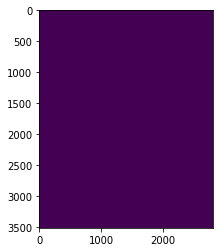

In [69]:
true_mask_list = os.listdir('true_masks_dir')

i = 0

path = 'true_masks_dir/' + true_mask_list[i]

image = plt.imread(path)

print(image.shape)

plt.imshow(image)

## Convert the pred bboxes into masks

In [70]:
# Create a folder to store the true val masks

if os.path.isdir('pred_masks_dir') != True:
    
    pred_masks_dir = 'pred_masks_dir'
    os.mkdir(pred_masks_dir)
    
!ls

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
VAST_Setup_Notebook_for_Mammo.ipynb   ports.log
best.pt				      pred_masks_dir
exp49_10f_df_data_w_folds.csv	      requirements.txt
exp50-mammo-yolov5-5-0-yolov5l.ipynb  smart-mammo-data
input				      true_masks_dir
my-yolov5-for-offline-use	      yolo_images_dir
onstart.log			      yolov5
onstart.sh


In [71]:
saved_list = []

df_test_preds = df_test_preds.reset_index(drop=True)

for i in tqdm(range(0, len(df_test_preds)), total=len(df_test_preds)):
    
    fname = df_test_preds.loc[i, 'id']
    
    # Read the image
    path = base_path + 'images_dir/images_dir/' + fname
    
    image = cv2.imread(path)
    
    # cv2 reads in BGR format therefore convert from BGR to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # create a blank mask
    mask = np.zeros((image.shape[0], image.shape[1])).astype(np.uint8)
    

        
    if fname not in saved_list:

        # image_png_size_list: [(h,w), ...]
        orig_image_h = image.shape[0]
        orig_image_w = image.shape[1]


        w = int(df_test_preds.loc[i,'bbox_width'] * orig_image_w)
        h = int(df_test_preds.loc[i,'bbox_height'] * orig_image_h)

        x_cent = orig_image_w * df_test_preds.loc[i,'x-center']
        y_cent = orig_image_h * df_test_preds.loc[i,'y-center']

        x = int(x_cent - (w / 2))
        y = int(y_cent - (h / 2))

        xmax = xmin + w
        ymax = ymin + h

        # Add the bbox mask to the blank mask created above.
        # Remember that in images the origin coord (0,0) is
        # in the top left corner and not in the botton left corner
        # like on a graph.
        mask[y:y+h, x:x+w] = 1

    else: # some pred images have more than one mask

        # Load the previous mask
        # Read the image
        path = 'pred_masks_dir/' + fname
        mask = plt.imread(path)

        # image_png_size_list: [(h,w), ...]
        orig_image_h = image.shape[0]
        orig_image_w = image.shape[1]


        w = int(df_test_preds.loc[i,'bbox_width'] * orig_image_w)
        h = int(df_test_preds.loc[i,'bbox_height'] * orig_image_h)

        x_cent = orig_image_w * df_test_preds.loc[i,'x-center']
        y_cent = orig_image_h * df_test_preds.loc[i,'y-center']

        x = int(x_cent - (w / 2))
        y = int(y_cent - (h / 2))

        xmax = xmin + w
        ymax = ymin + h

        # Add the bbox mask to the blank mask created above.
        # Remember that in images the origin coord (0,0) is
        # in the top left corner and not in the botton left corner
        # like on a graph.
        mask[y:y+h, x:x+w] = 1
        
    
    # Save the mask as an image in the folder
    # that we created.
    dst = os.path.join(pred_masks_dir, fname)
    
    cv2.imwrite(dst, mask)
    
    saved_list.append(fname)
    

# Check how mane files are in the new directory
file_list = os.listdir('pred_masks_dir')

len(file_list)

  0%|          | 0/79 [00:00<?, ?it/s]

76

In [72]:
# Create blank masks for all val images for which
# no bboxes were predicted.
# Store these masks in pred_masks_dir

pred_list = list(df_test_preds['id'])

for i in tqdm(range(0, len(df_val)), total=len(df_val)):
    
    fname = df_val.loc[i, 'id']
    
    if fname not in pred_list:
        
        path = base_path + 'images_dir/images_dir/' + fname
        image = cv2.imread(path)

        # cv2 reads in BGR format therefore convert from BGR to RGB.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # create a blank mask
        mask = np.zeros((image.shape[0], image.shape[1]))
        
        # Save the blank mask in pred_nasks_dir
        dst = os.path.join(pred_masks_dir, fname)

        cv2.imwrite(dst, mask)
        
        
# Check how mane files are in the new directory
file_list = os.listdir('pred_masks_dir')

len(file_list)

  0%|          | 0/146 [00:00<?, ?it/s]

132

(2812, 2012)


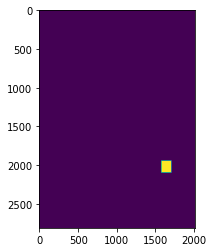

In [73]:
pred_mask_list = os.listdir('pred_masks_dir')

i = 21

path = 'true_masks_dir/' + pred_mask_list[i]

image = plt.imread(path)

print(image.shape)

plt.imshow(image)

## Test the iou code

In [74]:
def calculate_iou(y_true, y_pred):
    
    """
    Input: Numpy arrays with shape (image_h, image_w)
    Values must be either 1 or 0.
    
    Output: IOU value as a number.
    
    
    This works only for single images and not
    for a batch of images.
    """
    

    # If both images are blank
    if y_true.max() == 0 and y_pred.max() == 0:
        
        IOU = 'both_blank'
        
    else:
    
        # Set the matrix values to be either 1 or 0.
        # This can also be done like this: mask = (mask > 0).astype(np.uint8)
        y_true = y_true.astype(np.bool)
        y_pred = y_pred.astype(np.bool)

        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()

        result = (y_true_flat * y_pred_flat)

        area_of_intersection = np.sum(result)

        area_of_union = (np.sum(y_true_flat) + np.sum(y_pred_flat)) - area_of_intersection

        # add 0.00001 to prevent a zero division error.
        IOU = (area_of_intersection)/(area_of_union + 0.00001)

        # Round to three decimal places
        IOU = round(IOU, 3)
    
    return IOU

(3518, 2800)
float32
0.0
0.003921569


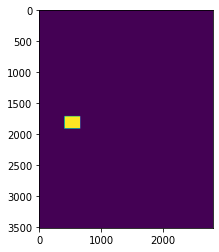

In [75]:
# Test the IOU function

pred_mask_list = os.listdir('pred_masks_dir')

i = 10

path = 'true_masks_dir/' + pred_mask_list[i]

mask = plt.imread(path) #.astype(np.bool)

# Threshold the mask
#mask = (mask > 0).astype(np.uint8)

print(mask.shape)
print(mask.dtype)
print(mask.min())
print(mask.max())

plt.imshow(mask)

In [76]:
# Change all values to zero
mask1 = mask * 0

In [77]:
# *** Note that if both masks are blank then the iou returned is 0.

y_true = mask1
y_pred = mask1

iou = calculate_iou(y_true, y_pred)

iou

'both_blank'

## Calculate the IOU for all val rows

In [78]:
iou_list = []

for i in tqdm(range(0, len(df_val)), total=len(df_val)):
    
    # Get the fname
    fname = df_val.loc[i, 'id']
    
    # Load the mask from true_masks_dir
    path = 'true_masks_dir/' + fname
    true_mask = plt.imread(path)
    
    
    # Load the pred mask
    path =  'pred_masks_dir/' + fname
    pred_mask = plt.imread(path)
    
    # Calculate the iou
    iou = calculate_iou(true_mask, pred_mask)
    
    iou_list.append(iou)
    
    
# Add iou list to df_val
df_val['iou'] = iou_list

  0%|          | 0/146 [00:00<?, ?it/s]

In [79]:
df = df_val[df_val['iou'] != 'both_blank']

print(df['iou'].min())
print(df['iou'].max())
print(df['iou'].mean())

0.0
0.923
0.3861550387596898


## Adjust the preds
There are cases where the true image has a bbox, and the model also predicted a bbox for that image - but the pred bbox did not overlap with the true bbox. In those cases we need to change the pred from 1 to 0.

In [80]:
def check_pred_iou(row):
    
    target = row['target']
    pred = row['preds']
    iou = row['iou']
    
    if target == 1 and pred == 1:
        
        if iou > 0:
            return pred # pred is 1
        else:
            return 0
    else:
        
        return pred

        
df_val['iou_preds'] = df_val.apply(check_pred_iou, axis=1)

In [81]:
df_val['iou_preds'].value_counts()

1    74
0    72
Name: iou_preds, dtype: int64

## Confusion Matrix

In [82]:
from sklearn.metrics import confusion_matrix

CLASS_LIST = ['Normal', 'Mass']
    
# targets
y_true = list(df_val['target'])

# get the preds as integers
#y_pred = list(df_val['preds'])
y_pred = list(df_val['iou_preds'])

# argmax returns the index of the max value in each row.
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix.
print()
print(cm)
print(CLASS_LIST)


[[17  3]
 [55 71]]
['Normal', 'Mass']


Confusion matrix, without normalization
[[17  3]
 [55 71]]


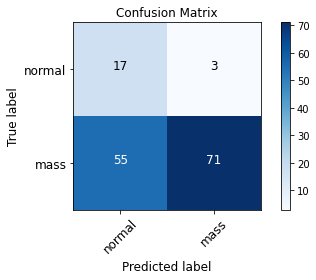

In [83]:
cm_plot_labels = ['normal', 'mass']

# Set the size of the plot.
#plt.figure(figsize=(10,7))

# Set the size of the text
text_size=12

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', text_size=text_size)

## Classification Report

In [84]:
from sklearn.metrics import classification_report
    
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print()
print(report)


              precision    recall  f1-score   support

      normal       0.24      0.85      0.37        20
        mass       0.96      0.56      0.71       126

    accuracy                           0.60       146
   macro avg       0.60      0.71      0.54       146
weighted avg       0.86      0.60      0.66       146



### Precision

Given a prediction, what is the probability that the prediction is correct. In other words, how much can we trust a prediction made by the model?

### Recall

What percentage of the total number of objects did the model detect? Given an object, what is the probability that the model will detect it? Example: Did the computer vision model in the self driving car detect all the pedestrians?

## Save df_val

In [85]:
path = 'df_val.csv'
df_val.to_csv(path, index=False)

## Delete images to prevent notebook commit errors

In [86]:
# change the working directory to yolov5

os.chdir(f'{root}/yolov5')

!pwd

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/root/yolov5


In [87]:
# Delete the folder to prevent a Kaggle error.

if os.path.isdir('base_dir') == True:
    shutil.rmtree('base_dir')

In [88]:
# change the working directory

os.chdir(root)

!pwd

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/root


In [89]:
# Delete the folder to prevent a Kaggle error.

if os.path.isdir('images_dir') == True:
    shutil.rmtree('images_dir')
    
if os.path.isdir('val_images_dir') == True:
    shutil.rmtree('val_images_dir')

In [90]:
!ls

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
VAST_Setup_Notebook_for_Mammo.ipynb   onstart.sh
best.pt				      ports.log
df_val.csv			      pred_masks_dir
exp49_10f_df_data_w_folds.csv	      requirements.txt
exp50-mammo-yolov5-5-0-yolov5l.ipynb  smart-mammo-data
input				      true_masks_dir
my-yolov5-for-offline-use	      yolo_images_dir
onstart.log			      yolov5
